# Importing necessary libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot



from matplotlib import style

# setting options
plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_rows = None
pd.options.display.max_columns = None


# **User Defined Functions**

In [66]:

def data_assessment(df):
    '''
    This function assesses the quality of the DataFrame.
    
    Args:
        df(DataFrame): Takes a DateFrame as input
    
    return:
        data(DataFrame): returns a DataFrame that depicts the data quality
        
    '''
    percent_missing = [str(round((df[col].isnull().sum()/len(df))*100,1))+'%' for col in df.columns]
    percent_complete = [str(round((1-(df[col].isnull().sum()/len(df)))*100,1))+'%' for col in df.columns]
    unique_values = [df[col].nunique() for col in df.columns]
    #mean = [df[col].mean if df[col].dtype!='object' else 'NIL' for col in df.columns]
    dtype = [df[col].dtype for col in df.columns]
    
    data = pd.DataFrame({'percent_complete':percent_complete,
                        'percent_missing':percent_missing,'unique_values':unique_values,
                        'dtype':dtype})
    data.index = df.columns
    
    return data

def numeric_dist_plot(df):
    '''
    Creates a dist plot for columns with numeric data type.
    
    Args:
        df(DataFrame): Takes a DateFrame as input
    
    return:
        None
    '''
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna(),hist_kws={'edgecolor':'white','color':'black'},kde=False)
            plt.tight_layout()
            plt.show()
            
def object_count_plot(df):
    '''
    Creates a count plot for columns with data type of object.
    
    Args:
        df(DataFrame): Takes a DateFrame as input
    
    return:
        None
    '''
    
    for col in df.columns:
        if df[col].dtype == 'object':
            print(col)
            for i in df[col].value_counts().index:
                prop = (df[col].value_counts()[i]/df[col].value_counts().sum())*100
                print(i,': ',prop,'%')
            
            plt.figure(figsize=(8,4))
            g = sns.countplot(x=col,data=df)
            #plt.title(col)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
            
def data_process(df,df2,cat_col,num_col,target,fill_num_na=True,fill_cat_na=True,encode=True):
    '''
    Encodes df and df2 using target guided encoding technique given that the target variable is binary.
    This function also fills numerical nan with the median, it fills non numerical nan with median also.
    
    Args:
        df(DataFrame): Takes a DateFrame as input
        categorical_col(list): A list of categorical columns to be encoded
        target(string): The name of the target column
    
    return:
        encoded(DataFrame): returns the encoded dataframe
    '''
    #filling numeric cols 
    if fill_num_na==True:
        for col in num_col: 
            df[col].fillna(df[col].mean(), inplace = True)
            df2[col].fillna(df2[col].mean(), inplace = True)
            
    else:
        pass
            
    #filling categorical cols
    if fill_cat_na==True:
        for col in cat_col:
            df[col].fillna('missing',inplace=True)
            df2[col].fillna('missing',inplace=True)
    else:
        pass
     
    #target guided encoding
    if encode==True:
        from sklearn.preprocessing import LabelEncoder

        
        if df[target].dtype=='object':
            labelencoder = LabelEncoder()
            df[target+'_encoding'] = labelencoder.fit_transform(df[target])
        else:
            pass
        
        for col in cat_col:
            ordinal_labels = df.groupby([col])[target+'_encoding'].mean().sort_values().index
            ordinal_labels2 = {k:i for i,k in enumerate(ordinal_labels,0)}
            df[col+'_encoded'] = df[col].map(ordinal_labels2)
            df2[col+'_encoded'] = df2[col].map(ordinal_labels2)
            
        df.drop(cat_col,axis=1,inplace=True) 
        df2.drop(cat_col,axis=1,inplace=True) 
        df.drop(target,axis=1,inplace=True)
    
    else:
        pass

        
    return df,df2


# Reading datasets

In [67]:
# reading the test and train datasets
train = pd.read_csv('../input/train-data/Train bootcamp.csv')
test = pd.read_csv('../input/test-data/Test bootcamp.csv')
test.drop('Applicant_ID',1,inplace=True)
train.drop('Applicant_ID',1,inplace=True)

# Visualizing the completeness of the dataset

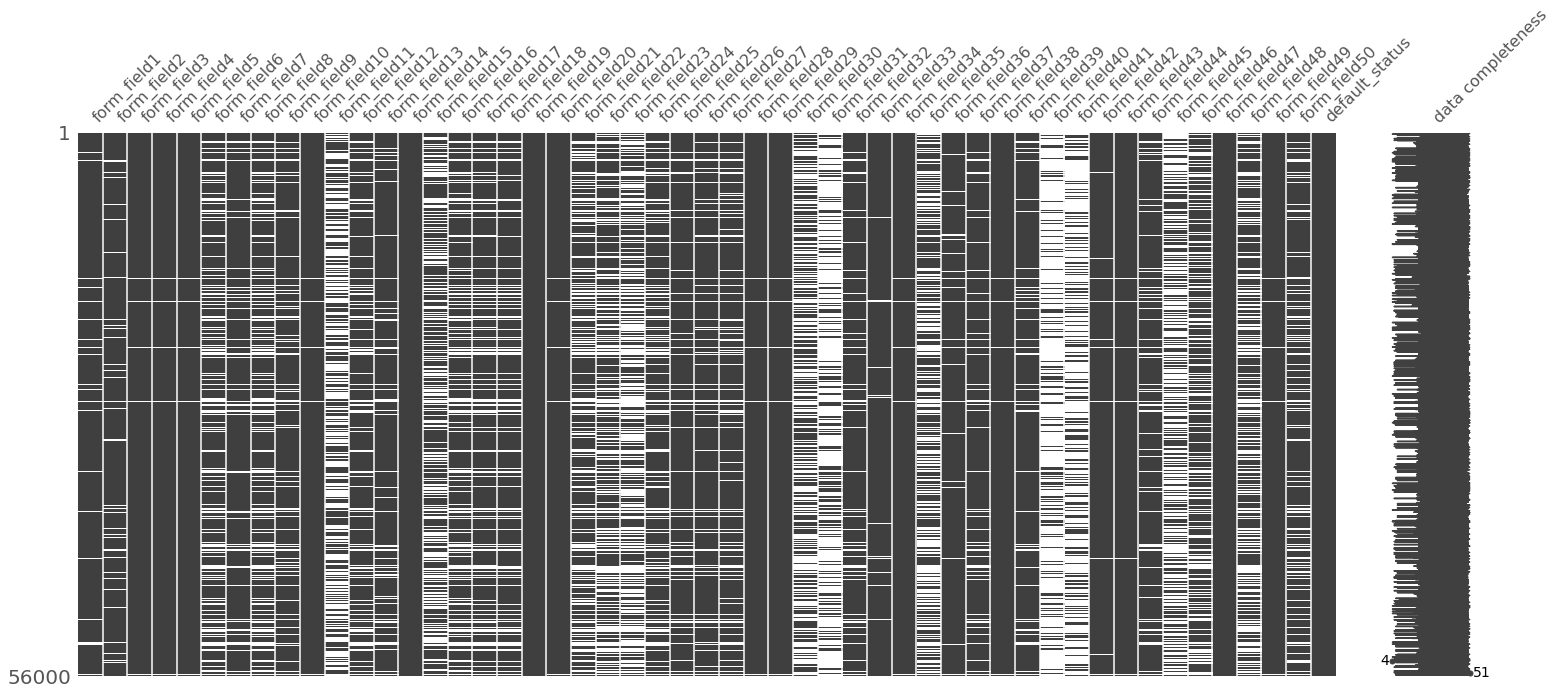

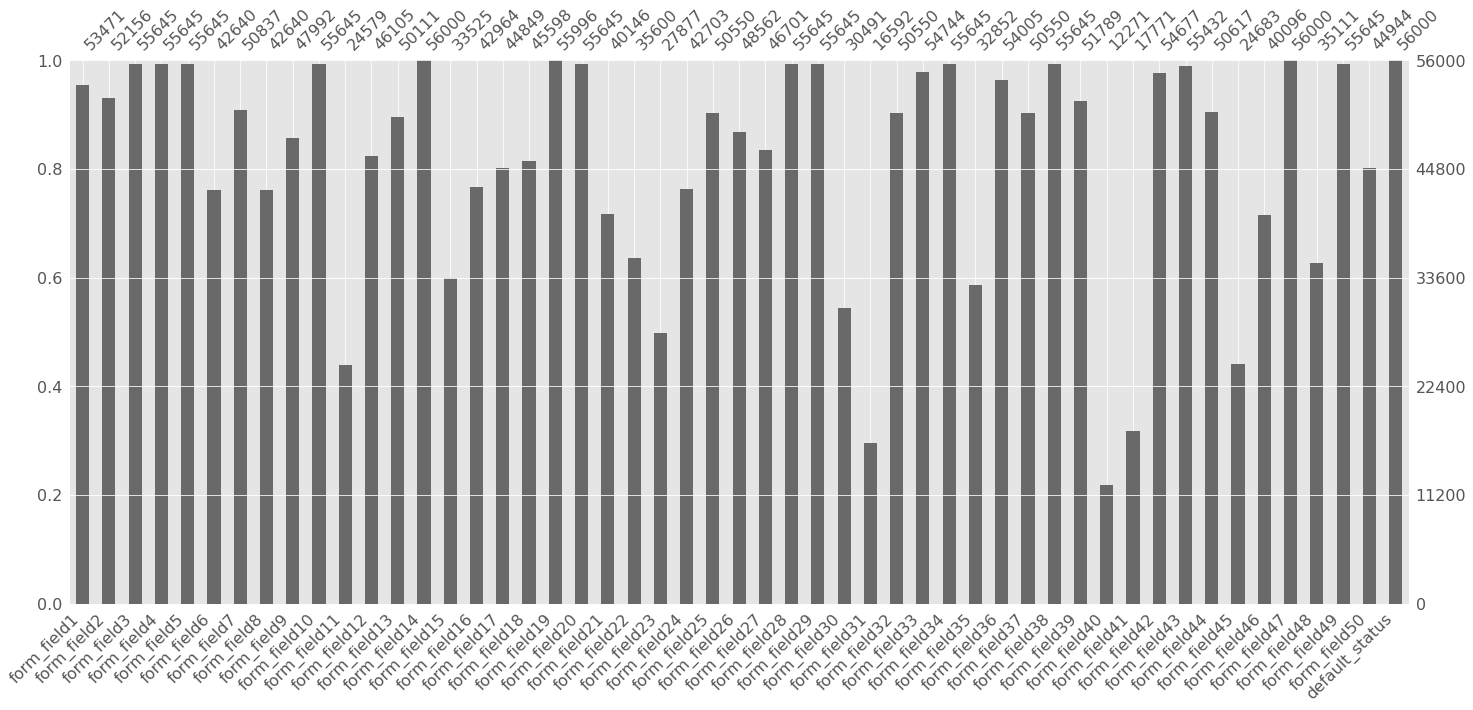

In [68]:
## Visualizing missing values

# Matrix plot
msno.matrix(train,labels=True)
plt.show()

# barplot
msno.bar(train,labels=True)
plt.show()

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   form_field1     53471 non-null  float64
 1   form_field2     52156 non-null  float64
 2   form_field3     55645 non-null  float64
 3   form_field4     55645 non-null  float64
 4   form_field5     55645 non-null  float64
 5   form_field6     42640 non-null  float64
 6   form_field7     50837 non-null  float64
 7   form_field8     42640 non-null  float64
 8   form_field9     47992 non-null  float64
 9   form_field10    55645 non-null  float64
 10  form_field11    24579 non-null  float64
 11  form_field12    46105 non-null  float64
 12  form_field13    50111 non-null  float64
 13  form_field14    56000 non-null  int64  
 14  form_field15    33525 non-null  float64
 15  form_field16    42964 non-null  float64
 16  form_field17    44849 non-null  float64
 17  form_field18    45598 non-null 

In [70]:
## dropping columns with more than 70% nan values 
# there are 51 columns, 70% of 51 is approx 36.
# we will drop rows that dont have up to 36 filled columns

train.dropna(thresh=36,inplace=True)
print('The dataset now contains',len(train.index), 'rows')

The dataset now contains 45546 rows


In [71]:
## Assessing the dataset

data_assessment(train)

,percent_complete,percent_missing,unique_values,dtype
form_field1,99.6%,0.4%,441,float64
form_field2,94.3%,5.7%,17904,float64
form_field3,100.0%,0.0%,11116,float64
form_field4,100.0%,0.0%,2236,float64
form_field5,100.0%,0.0%,1940,float64
form_field6,93.2%,6.8%,5792,float64
form_field7,99.7%,0.3%,22454,float64
form_field8,93.2%,6.8%,12779,float64
form_field9,97.8%,2.2%,22185,float64
form_field10,100.0%,0.0%,30029,float64


* from the above df we can see that some columns have a completeness of less than 60%. We will now go ahed and drop them.

In [72]:

train.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [73]:
## filling missing values 

## The data_process function can be used to fill both categorical and numerical nan values.
 # it can also encode non numerical columns unsing a technique called target guided encoding.

cat_col = list(train.select_dtypes(['object']).drop('default_status',axis=1).columns) # categorical columns
num_col = list(train.select_dtypes([np.number]).columns) # numerical columns
target = 'default_status' # target

df = data_process(train.copy(),test.copy(),cat_col,num_col,target,fill_num_na=True,fill_cat_na=True,encode=False)
#df2 = data_process(toy.copy(),test.copy(),cat_col,num_col,target,fill_num_na=True,fill_cat_na=True,encode=False)

In [74]:
## assigning the cleaned datasets to new variables

train_set = df[0]
test_set = df[1]
#toy_set = df2[0]

#assessing train_set
data_assessment(train_set)

,percent_complete,percent_missing,unique_values,dtype
form_field1,100.0%,0.0%,442,float64
form_field2,100.0%,0.0%,17905,float64
form_field3,100.0%,0.0%,11116,float64
form_field4,100.0%,0.0%,2236,float64
form_field5,100.0%,0.0%,1940,float64
form_field6,100.0%,0.0%,5793,float64
form_field7,100.0%,0.0%,22455,float64
form_field8,100.0%,0.0%,12780,float64
form_field9,100.0%,0.0%,22186,float64
form_field10,100.0%,0.0%,30029,float64


# EDA

Here some basic EDA is performed

count    45546.000000
mean      3527.991141
std        172.908669
min       2990.000000
25%       3410.000000
50%       3514.000000
75%       3646.000000
max       3900.000000
Name: form_field1, dtype: float64


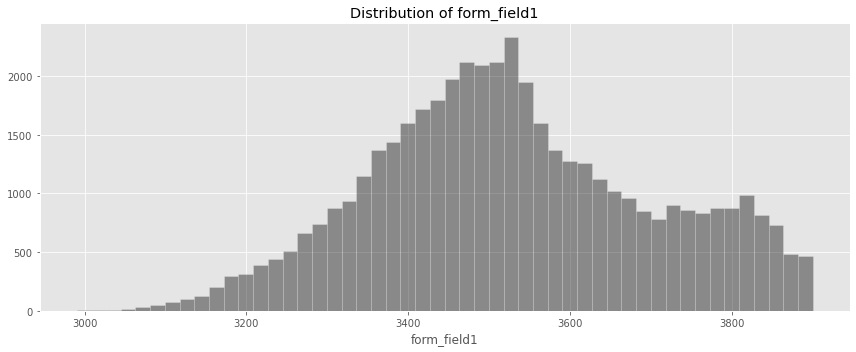

count    45546.000000
mean         0.545379
std          0.798965
min          0.000000
25%          0.075050
50%          0.294975
75%          0.676063
max         18.015050
Name: form_field2, dtype: float64


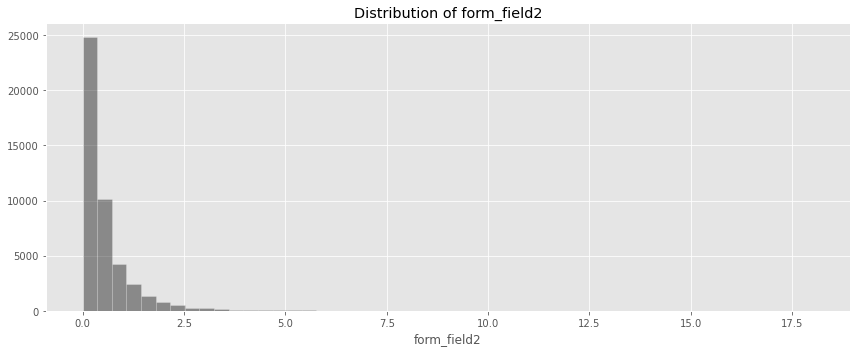

count    45546.000000
mean         0.823709
std          1.846511
min          0.000000
25%          0.000000
50%          0.000000
75%          0.781400
max         34.687800
Name: form_field3, dtype: float64


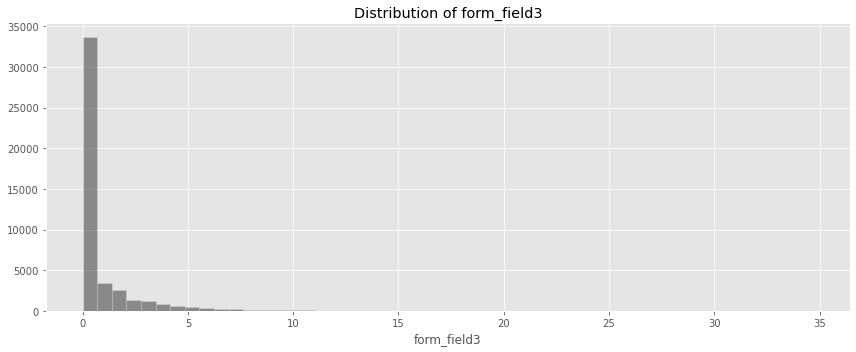

count    45546.000000
mean         0.649162
std          2.709405
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         91.672200
Name: form_field4, dtype: float64


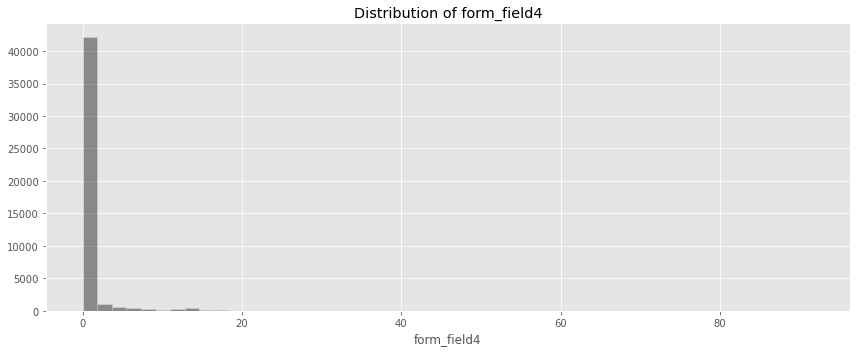

count    45546.000000
mean         1.216199
std          7.661039
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        312.190200
Name: form_field5, dtype: float64


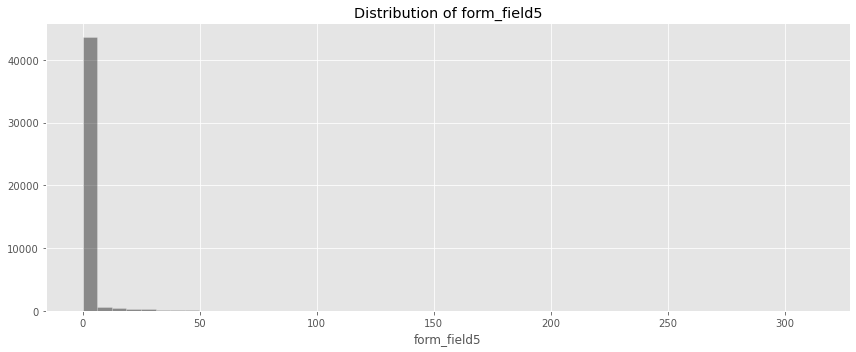

count    4.554600e+04
mean     6.179369e+05
std      1.370731e+06
min      0.000000e+00
25%      1.789400e+04
50%      1.443190e+05
75%      6.179369e+05
max      5.313546e+07
Name: form_field6, dtype: float64


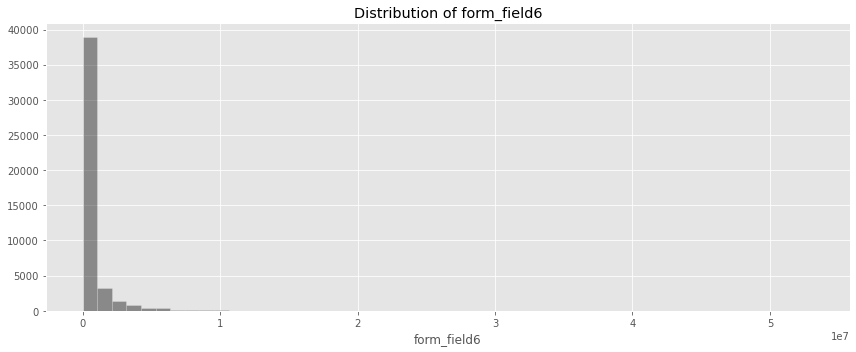

count    4.554600e+04
mean     7.400800e+06
std      2.000282e+07
min      0.000000e+00
25%      9.071480e+05
50%      3.105970e+06
75%      7.547378e+06
max      2.158794e+09
Name: form_field7, dtype: float64


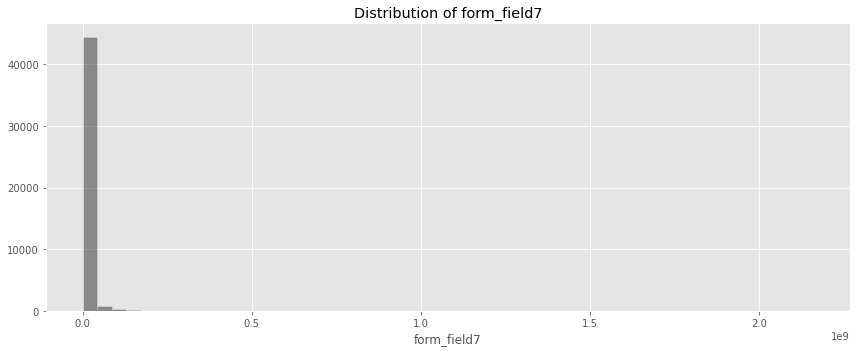

count    4.554600e+04
mean     2.625715e+06
std      3.791034e+06
min      0.000000e+00
25%      2.003350e+05
50%      1.156497e+06
75%      3.359112e+06
max      1.037397e+08
Name: form_field8, dtype: float64


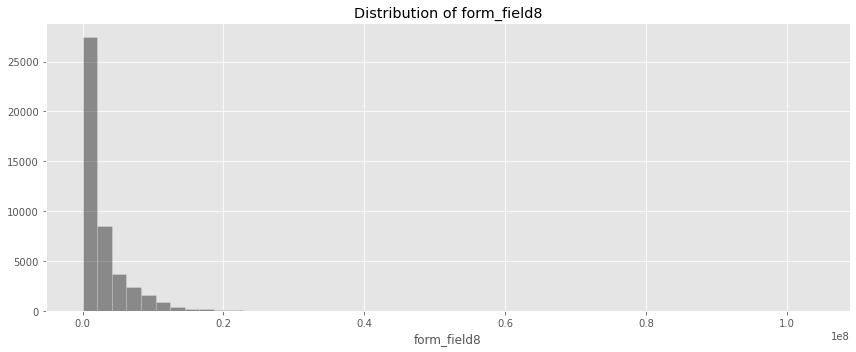

count    4.554600e+04
mean     1.400461e+07
std      1.994005e+07
min      0.000000e+00
25%      1.831023e+06
50%      6.611444e+06
75%      1.788836e+07
max      3.200533e+08
Name: form_field9, dtype: float64


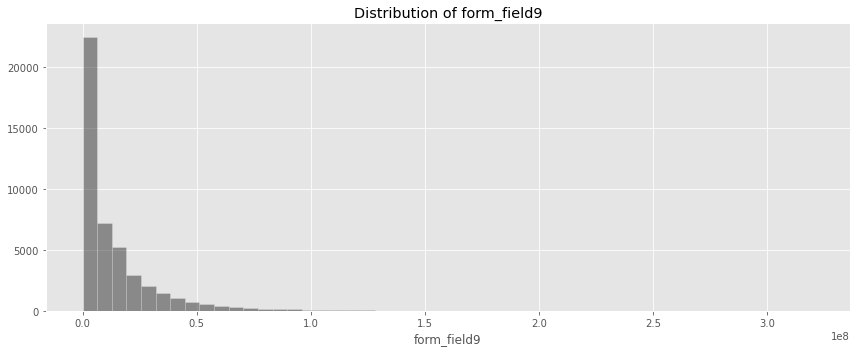

count    4.554600e+04
mean     1.413780e+07
std      2.884978e+07
min      0.000000e+00
25%      1.388827e+06
50%      5.676872e+06
75%      1.653765e+07
max      2.191361e+09
Name: form_field10, dtype: float64


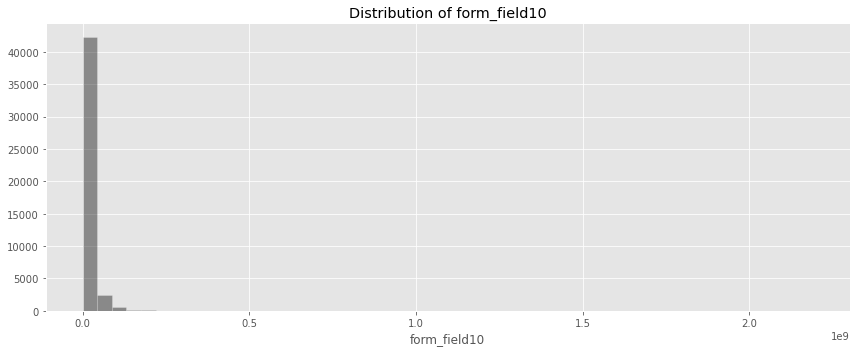

count    4.554600e+04
mean     1.753850e+06
std      2.807505e+06
min      0.000000e+00
25%      1.209790e+06
50%      1.753850e+06
75%      1.753850e+06
max      1.707430e+08
Name: form_field11, dtype: float64


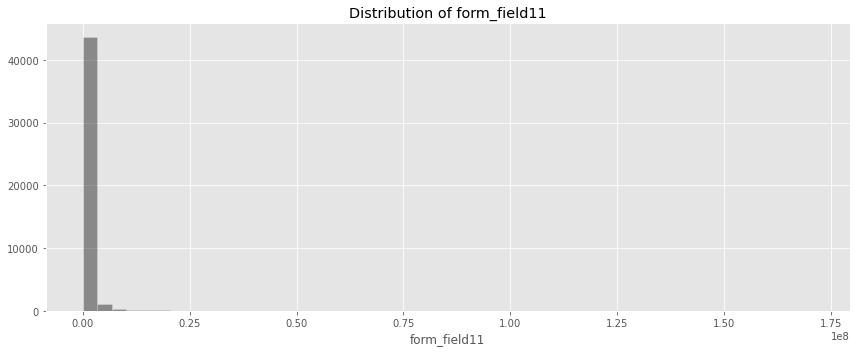

count    4.554600e+04
mean     2.845300e+06
std      4.546366e+06
min      0.000000e+00
25%      3.267600e+05
50%      1.279810e+06
75%      3.393928e+06
max      1.240439e+08
Name: form_field12, dtype: float64


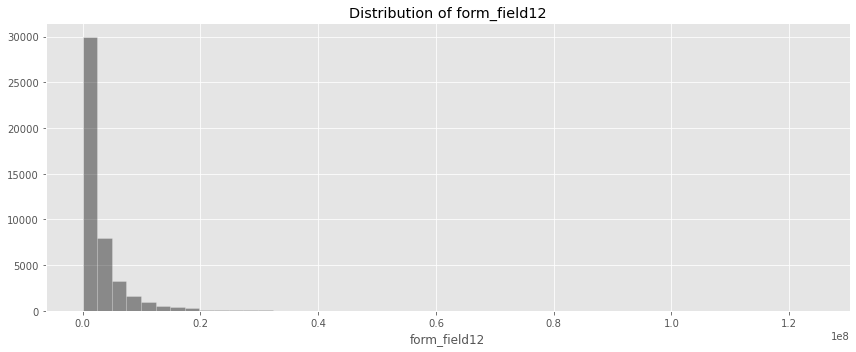

count    4.554600e+04
mean     6.767492e+06
std      2.439349e+07
min      0.000000e+00
25%      5.365282e+05
50%      2.291016e+06
75%      6.767492e+06
max      2.457824e+09
Name: form_field13, dtype: float64


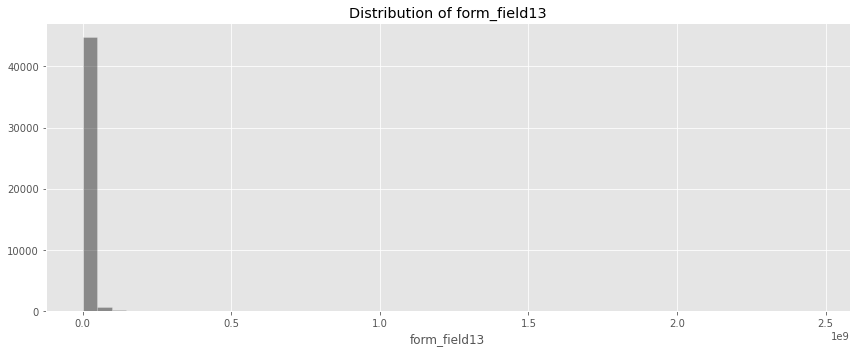

count    4.554600e+04
mean     5.316511e+07
std      1.052743e+09
min      0.000000e+00
25%      1.927495e+07
50%      2.891242e+07
75%      4.818738e+07
max      1.542150e+11
Name: form_field14, dtype: float64


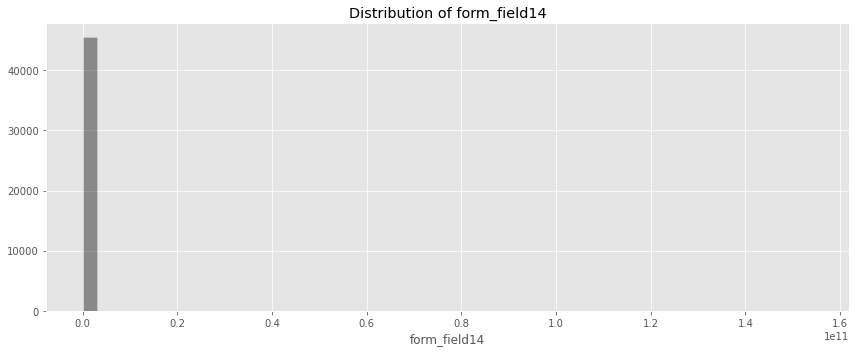

count    4.554600e+04
mean     1.197182e+08
std      9.173233e+07
min      5.395430e+05
25%      7.349027e+07
50%      1.197182e+08
75%      1.197182e+08
max      3.456119e+09
Name: form_field15, dtype: float64


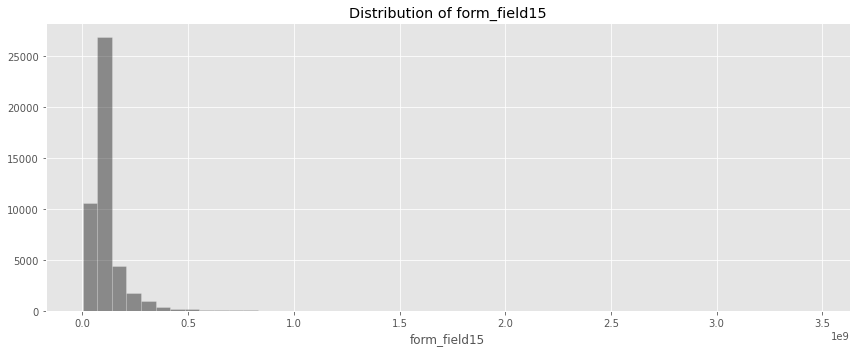

count    45546.000000
mean         0.231728
std          0.603646
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: form_field16, dtype: float64


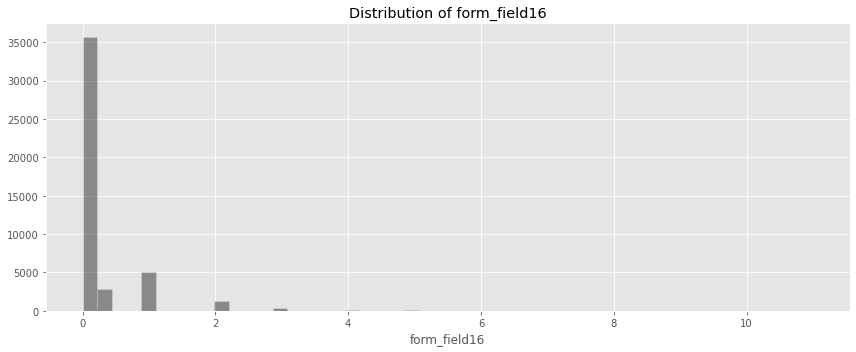

count    45546.000000
mean         0.269027
std          0.713604
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: form_field17, dtype: float64


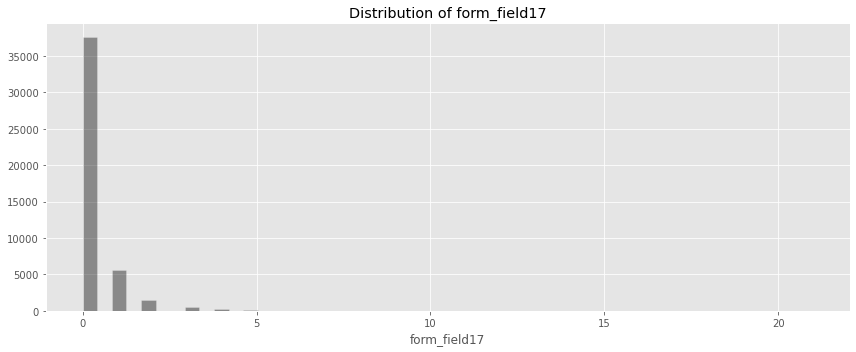

count    45546.000000
mean         0.277802
std          0.723874
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         21.000000
Name: form_field18, dtype: float64


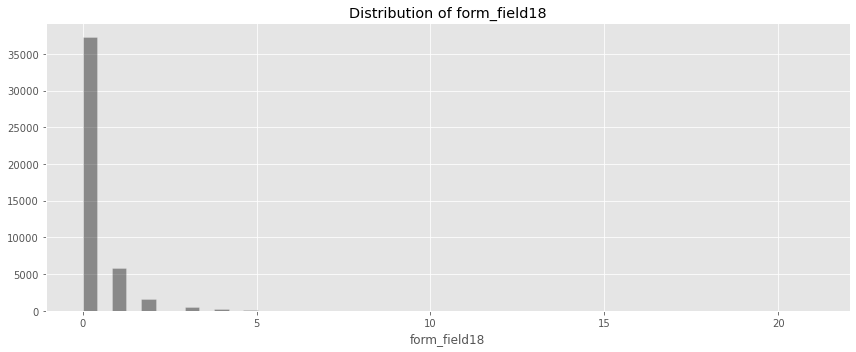

count    45546.000000
mean         1.162956
std          1.859073
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         28.000000
Name: form_field19, dtype: float64


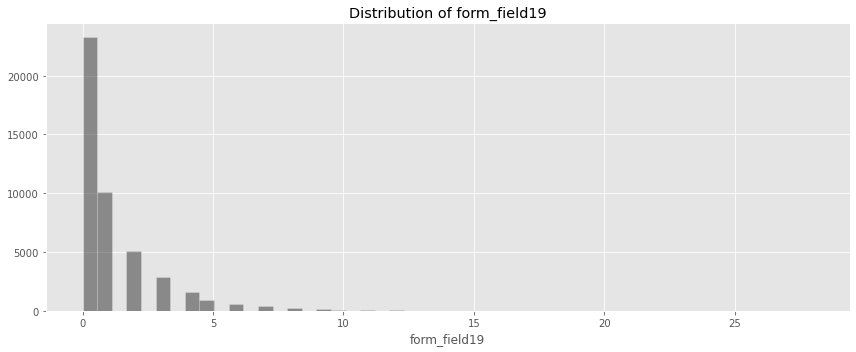

count    45546.000000
mean         1.250648
std          1.901855
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         29.000000
Name: form_field20, dtype: float64


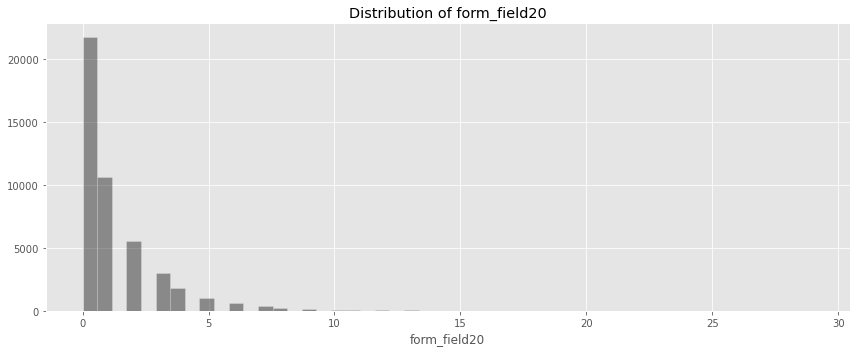

count    45546.000000
mean        86.420646
std         49.878051
min          0.375000
25%         47.265000
50%         86.420646
75%        124.661250
max       1957.875000
Name: form_field21, dtype: float64


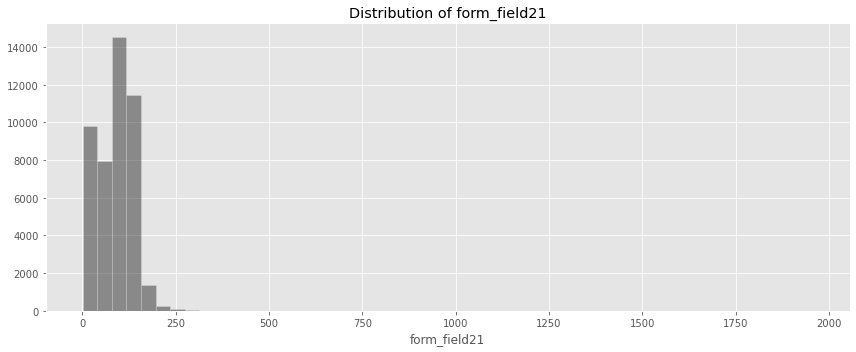

count    45546.00000
mean      6618.98932
std       4954.50901
min          0.00000
25%       2400.00000
50%       6618.98932
75%       9675.00000
max      97200.00000
Name: form_field22, dtype: float64


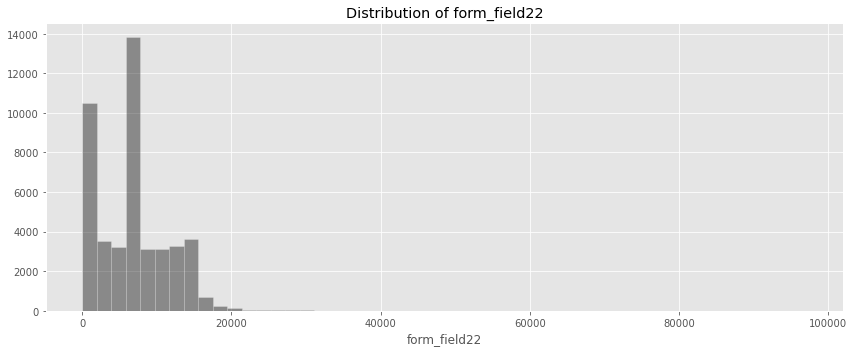

count    45546.000000
mean      6460.960616
std       4472.364208
min          0.000000
25%       3735.180000
50%       6460.960616
75%       7507.417500
max      97200.000000
Name: form_field23, dtype: float64


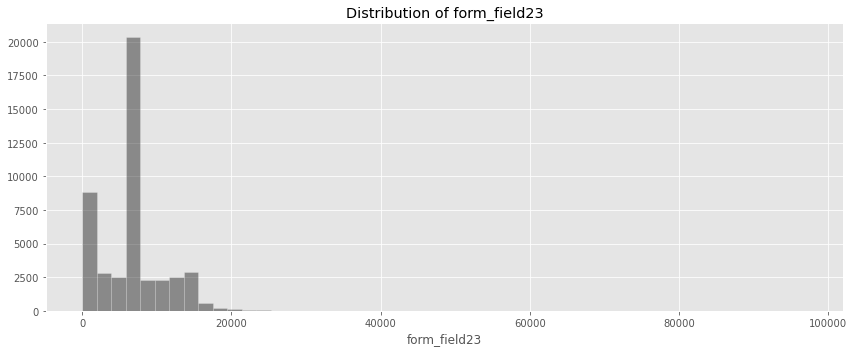

count    45546.000000
mean       104.498583
std        421.351012
min          0.000000
25%         18.213750
50%         68.775000
75%        109.965000
max      31863.750000
Name: form_field24, dtype: float64


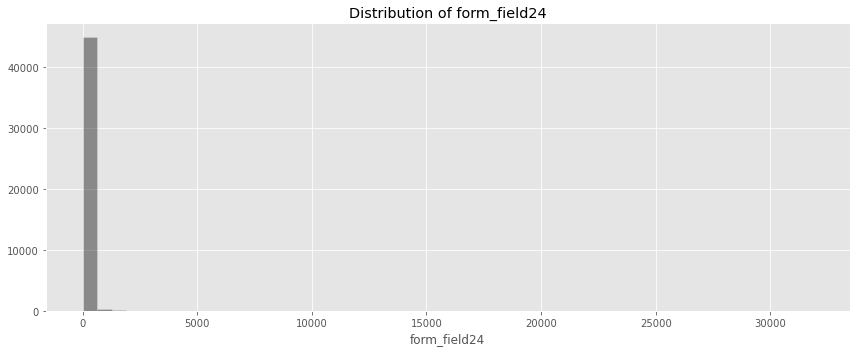

count    45546.000000
mean      2671.972406
std       1961.022335
min          0.000000
25%       1278.000000
50%       2281.500000
75%       3576.000000
max      25093.500000
Name: form_field25, dtype: float64


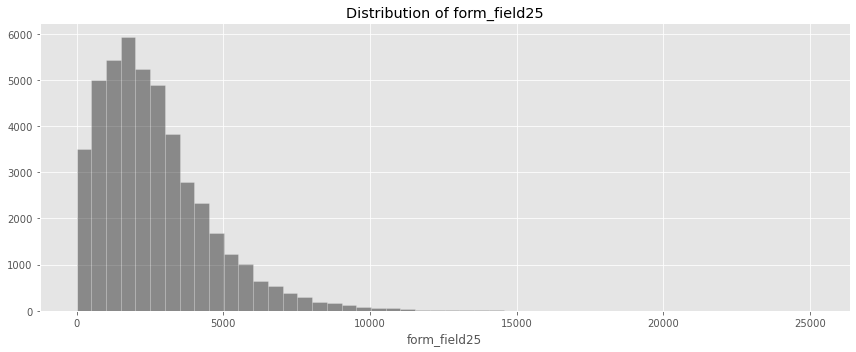

count    45546.000000
mean     10425.337602
std       8872.354053
min          0.000000
25%       3558.000000
50%       8760.000000
75%      14508.000000
max      73275.000000
Name: form_field26, dtype: float64


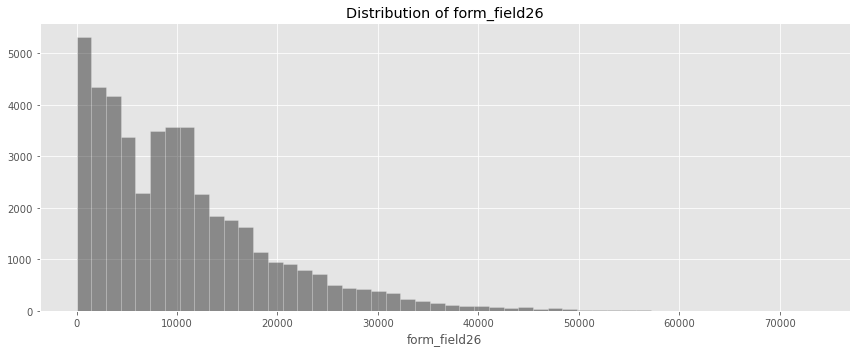

count    45546.000000
mean      6321.713301
std       5364.991686
min          0.000000
25%       2190.000000
50%       5536.000000
75%       8700.000000
max      42522.000000
Name: form_field27, dtype: float64


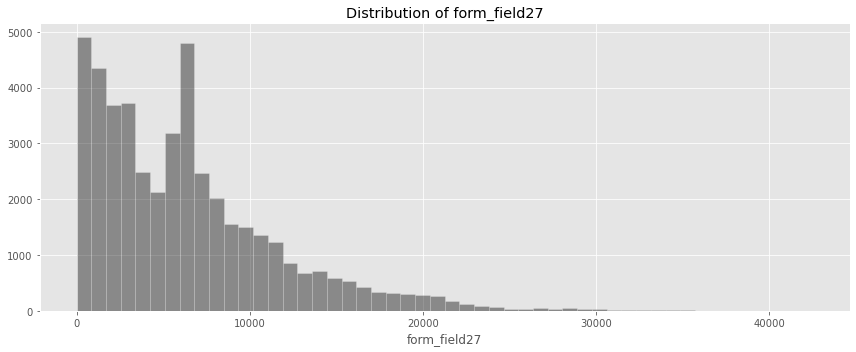

count    45546.000000
mean     19663.045800
std      27913.849684
min          0.000000
25%         60.000000
50%        852.000000
75%      60772.000000
max      60772.000000
Name: form_field28, dtype: float64


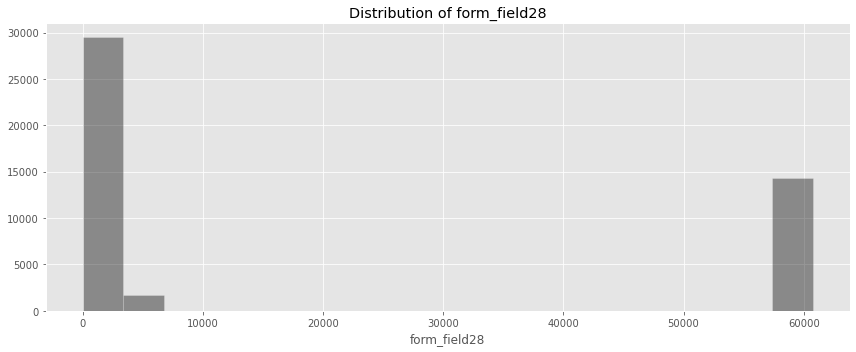

count    45546.000000
mean     17661.614082
std       9716.698264
min         90.000000
25%      11040.000000
50%      16242.000000
75%      22812.000000
max      73914.000000
Name: form_field29, dtype: float64


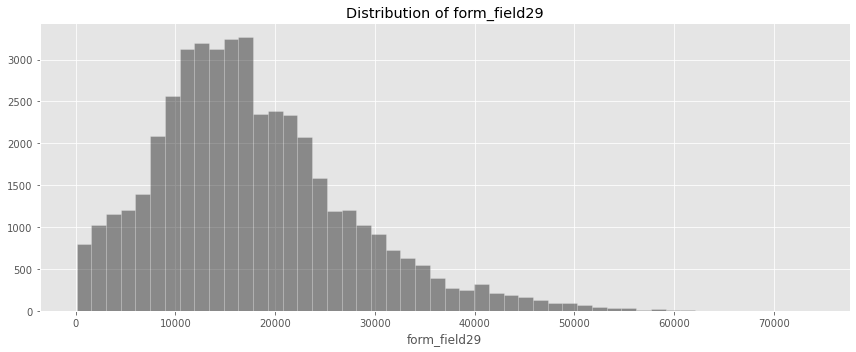

count    45546.000000
mean      5293.219993
std       2408.917995
min          0.000000
25%       4866.000000
50%       5293.219993
75%       6448.000000
max      25550.000000
Name: form_field30, dtype: float64


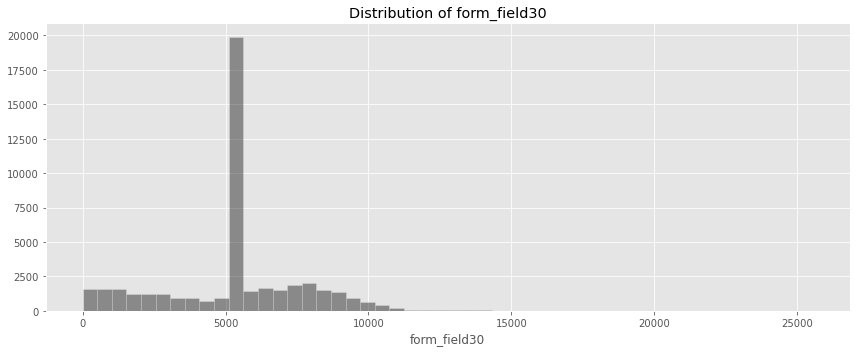

count    45546.000000
mean     11251.180442
std       3270.204335
min          0.000000
25%      11251.180442
50%      11251.180442
75%      11251.180442
max      47085.000000
Name: form_field31, dtype: float64


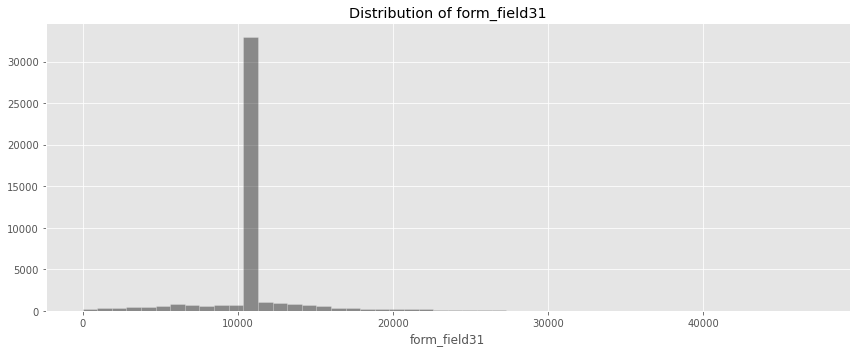

count    45546.000000
mean      1011.676901
std       1065.674767
min          0.000000
25%        246.000000
50%        692.000000
75%       1426.000000
max      21306.000000
Name: form_field32, dtype: float64


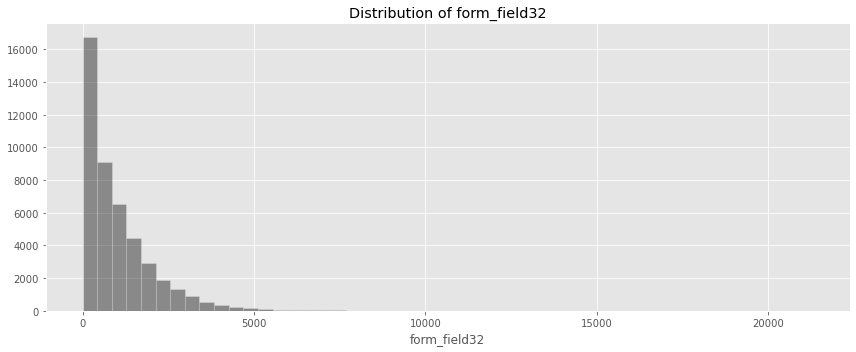

count    45546.000000
mean        14.785648
std         15.394780
min          0.166600
25%          2.833400
50%          9.166600
75%         22.166600
max        152.000000
Name: form_field33, dtype: float64


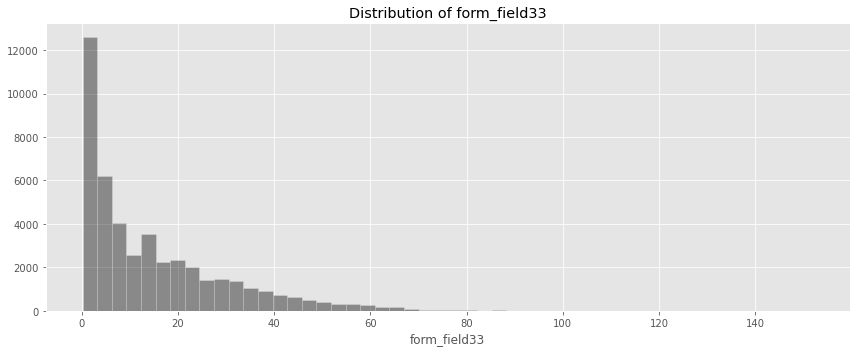

count    45546.000000
mean         0.256246
std          0.716819
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: form_field34, dtype: float64


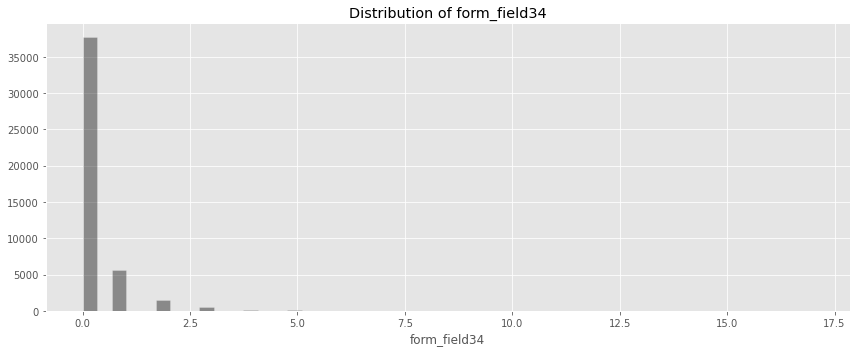

count    45546.000000
mean         0.180039
std          0.463868
min          0.000000
25%          0.000000
50%          0.000000
75%          0.180039
max         10.000000
Name: form_field35, dtype: float64


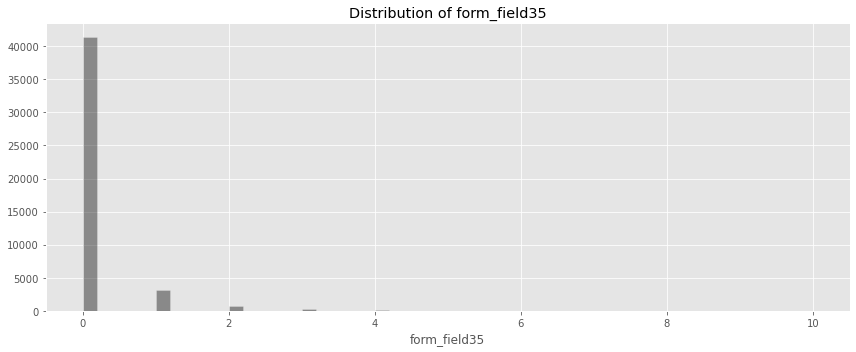

count    45546.000000
mean        12.878234
std         10.008384
min          2.000000
25%          6.000000
50%         10.000000
75%         16.000000
max        134.000000
Name: form_field36, dtype: float64


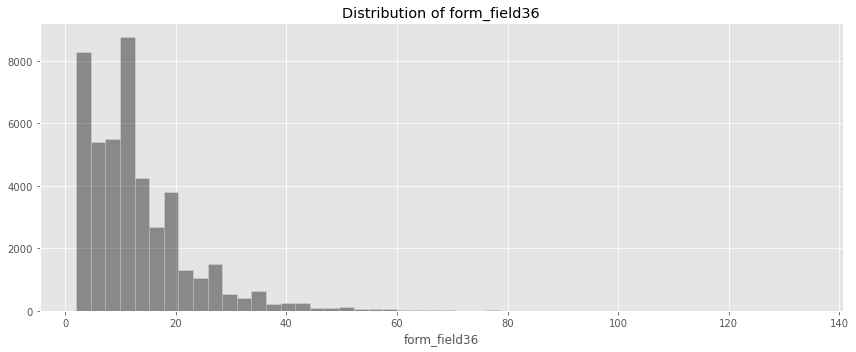

count    45546.000000
mean         9.031675
std          9.520361
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        106.000000
Name: form_field37, dtype: float64


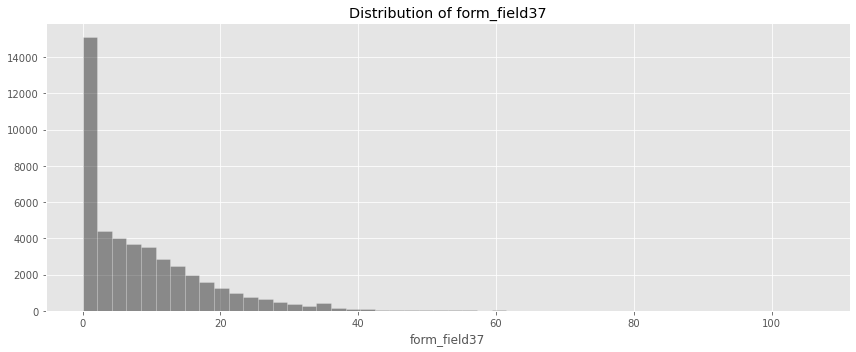

count    45546.000000
mean         8.941773
std          7.825846
min          0.000000
25%          4.000000
50%          8.000000
75%         12.000000
max        142.000000
Name: form_field38, dtype: float64


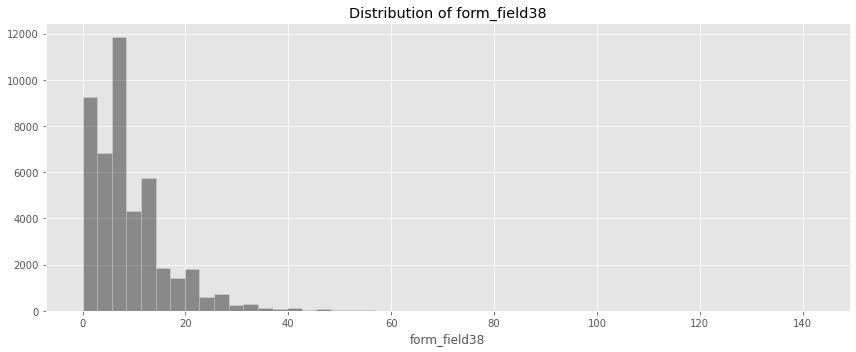

count    45546.000000
mean         0.088370
std          0.404617
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: form_field39, dtype: float64


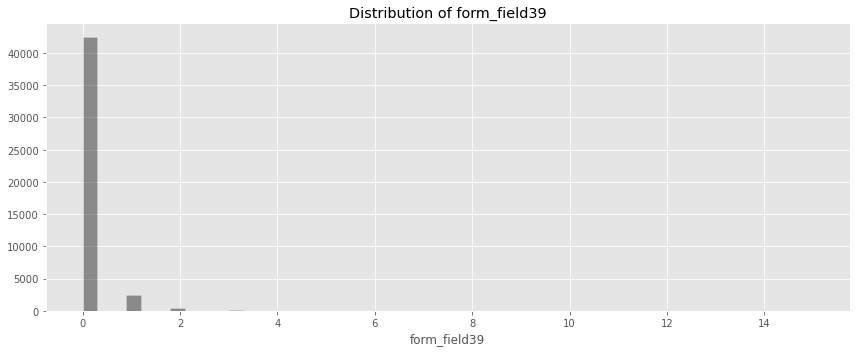

count    45546.000000
mean       145.114494
std         22.035320
min          0.021000
25%        145.114494
50%        145.114494
75%        145.114494
max        645.450000
Name: form_field40, dtype: float64


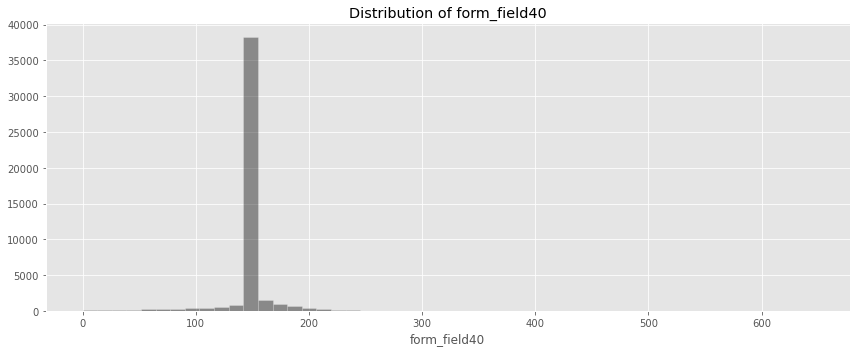

count    45546.000000
mean       107.285586
std         22.022841
min          0.000000
25%        107.285586
50%        107.285586
75%        107.285586
max        255.000000
Name: form_field41, dtype: float64


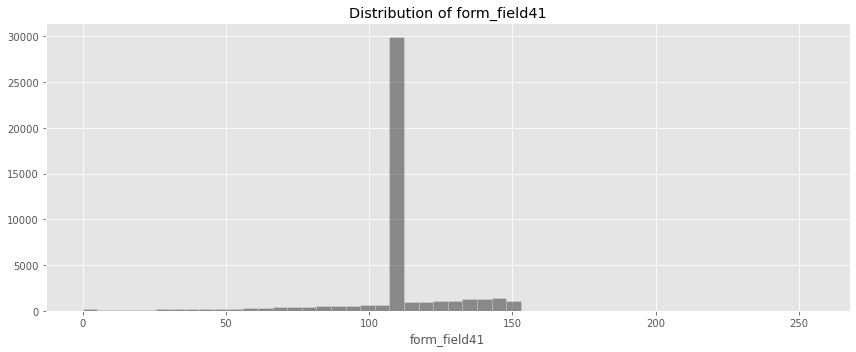

count    45546.000000
mean         0.253830
std          0.304062
min          0.000000
25%          0.000000
50%          0.137500
75%          0.425810
max          2.200000
Name: form_field42, dtype: float64


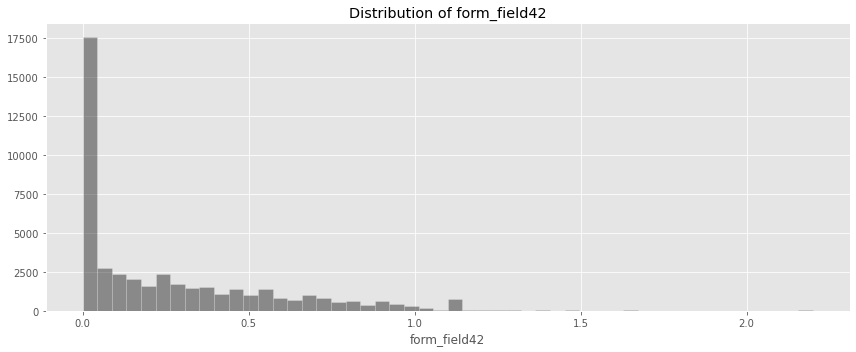

count    45546.000000
mean         7.802604
std          6.345144
min          0.000000
25%          3.030000
50%          6.060000
75%         11.110000
max         78.780000
Name: form_field43, dtype: float64


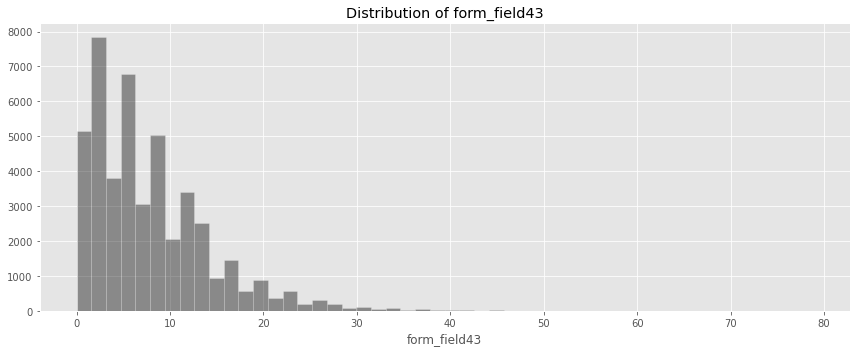

count    45546.000000
mean         0.553597
std          0.191298
min          0.048528
25%          0.408118
50%          0.568416
75%          0.732060
max          0.800000
Name: form_field44, dtype: float64


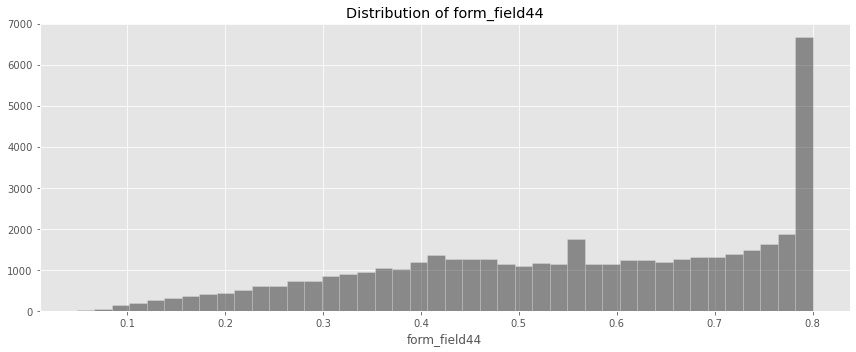

count    45546.000000
mean         0.062446
std          0.192876
min          0.000000
25%          0.000000
50%          0.062446
75%          0.062446
max          5.000000
Name: form_field45, dtype: float64


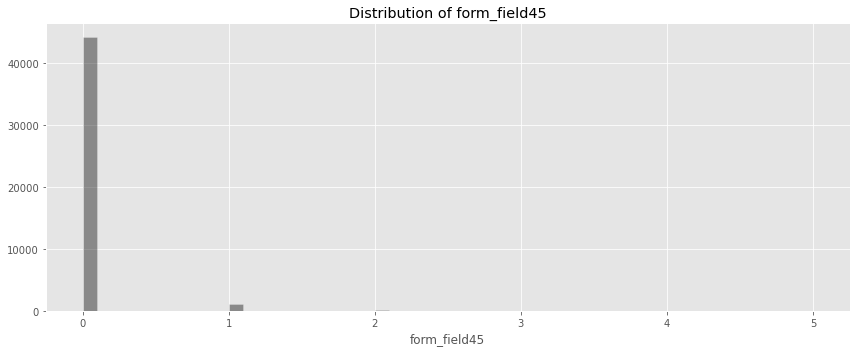

count    45546.000000
mean         0.066340
std          0.248092
min          0.000000
25%          0.000000
50%          0.000000
75%          0.066340
max          5.000000
Name: form_field46, dtype: float64


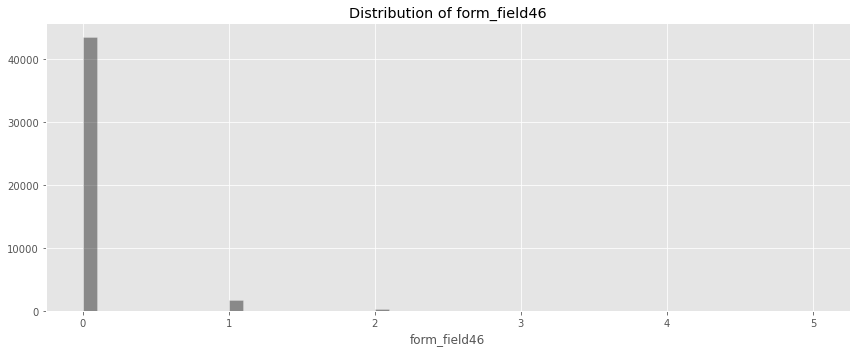

count    4.554600e+04
mean     3.076472e+05
std      1.446534e+06
min      0.000000e+00
25%      1.335441e+02
50%      6.670667e+02
75%      3.076472e+05
max      5.321014e+07
Name: form_field48, dtype: float64


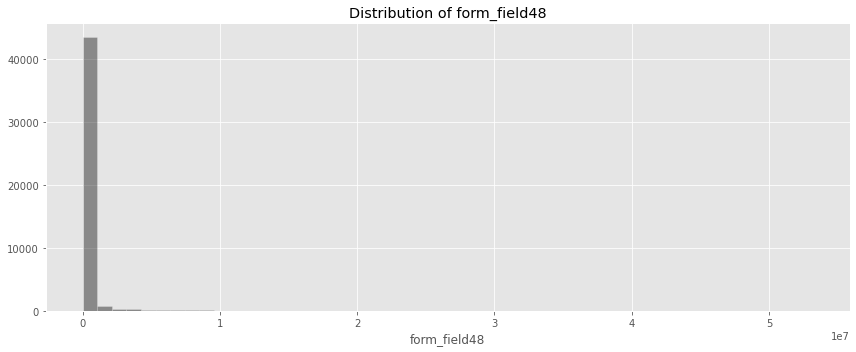

count    45546.000000
mean         1.108354
std          1.788795
min          0.000000
25%          0.000000
50%          0.274760
75%          1.488927
max         28.000000
Name: form_field49, dtype: float64


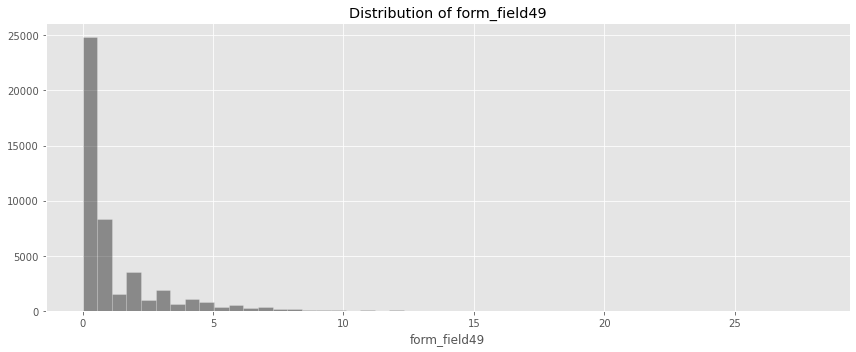

count    4.554600e+04
mean     6.346283e+05
std      5.698317e+06
min      0.000000e+00
25%      6.399907e-02
50%      2.251860e-01
75%      7.258089e-01
max      1.988498e+08
Name: form_field50, dtype: float64


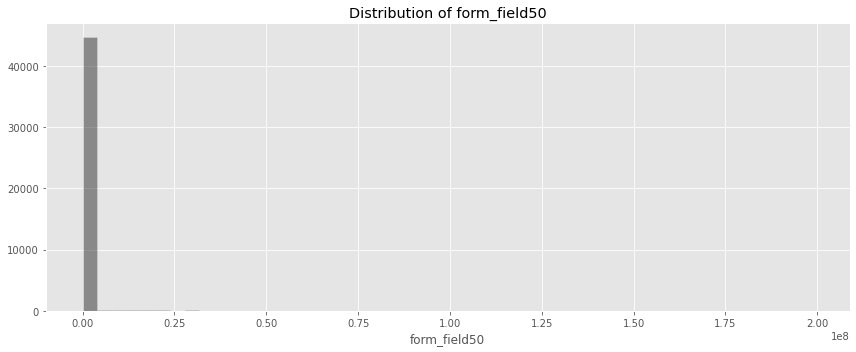

In [75]:
## Checking numerical distribution plots for all numeric columns

numeric_dist_plot(train_set)

form_field47
charge :  62.661924208492515 %
lending :  37.338075791507485 %


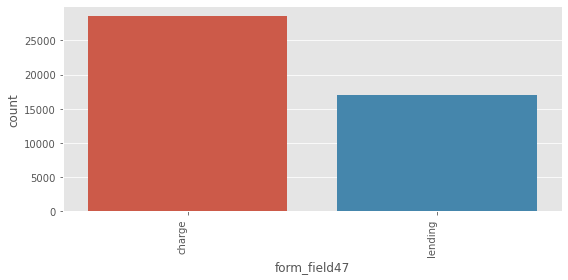

default_status
no :  79.65353708338823 %
yes :  20.346462916611777 %


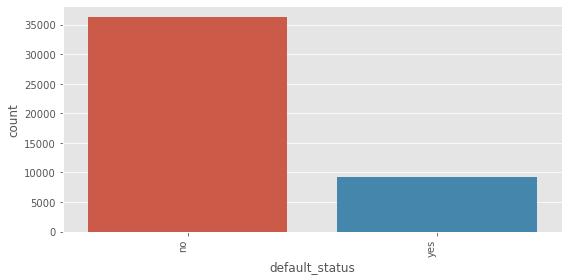

In [76]:
## checking object count plot for columns with object dtype that have default_status=yes

object_count_plot(train_set)

form_field47
charge :  62.661924208492515 %
lending :  37.338075791507485 %


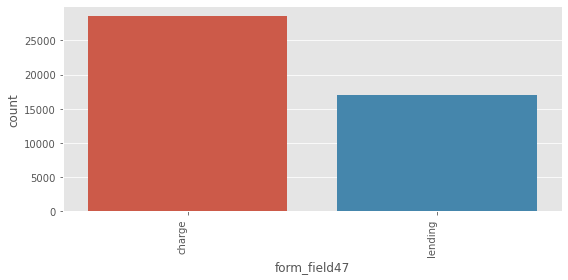

default_status
no :  79.65353708338823 %
yes :  20.346462916611777 %


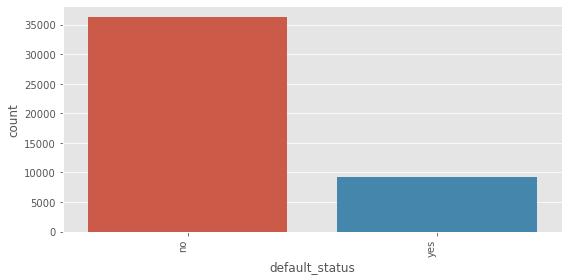

In [77]:
## checking object count plot for columns with object dtype

object_count_plot(train_set)

form_field47
charge :  57.57600815899004 %
lending :  42.42399184100995 %


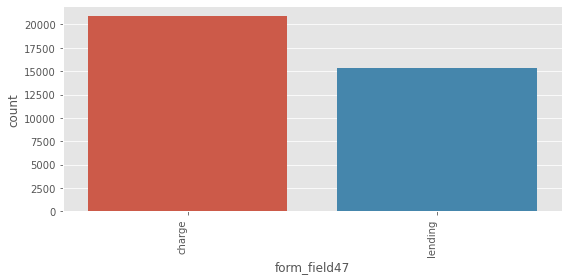

default_status
no :  100.0 %


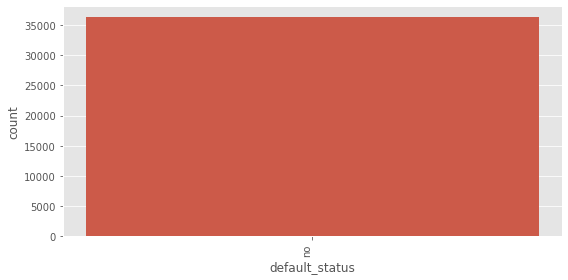

In [78]:
## checking object count plot for columns with object dtype that have default_status=no

object_count_plot(train_set[train_set['default_status']=='no'])

# Building the model

In [79]:
## main train-test-split
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train_set, train_set['default_status'], train_size=0.75)

In [80]:
xc = X_train.copy()
xv = X_validation.copy()

## encoding form_field47 using 1 for charged and 0 for lending
def_h = {'charge':1, 'lending':0}
xc['form_field47'] =xc['form_field47'].map(def_h)
xv['form_field47'] =xv['form_field47'].map(def_h)
test_set['form_field47'] =test_set['form_field47'].map(def_h)

In [81]:
##CATBOOST CLASSIFIER 


#categorical_features_indices = np.where(X.dtypes  == 'object')[0]

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import KFoldq
##from sklearn.model_selection import cross_val_score
#from numpy import mean
#from numpy import std

#X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75)

from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

params = {
    'iterations': 700,
    'learning_rate': 0.03,
    'eval_metric': 'Accuracy',
    'logging_level': 'Silent',
    'use_best_model': True,
     #'n_estimators':5000
    'depth':7,
    #'loss_function': 'CrossEntropy'
    'l2_leaf_reg':10
}


catboost_model2 = CatBoostClassifier(**params)
train_pool = Pool(xc.drop('default_status', axis=1), y_train)
validate_pool = Pool(xv.drop('default_status', axis=1), y_validation)

catboost_model2.fit(train_pool, eval_set=validate_pool)

test_set_cat2 = xv.drop('default_status', axis=1)
pred_prob = catboost_model2.predict_proba(xv.drop('default_status', axis=1))
roc_auc_score(y_validation, pred_prob[:,1])

0.8358354099149048

In [82]:
test_set.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,3236.000000,0.34875,10.2006,0.0000,0.0,418564.00000,4.185640e+05,4.185640e+05,5.407100e+05,0.0,1649749.0,5.446000e+03,0.000000e+00,48187375,1.146861e+08,0.000000,0.000000,0.000000,0.0,0.0,87.11408,6653.189477,6473.026142,105.934375,1086.00000,6204.000000,2676.000000,60.0,14691.0,9794.000000,10934.016134,238.000000,1.8334,0.0,0.194071,22.0,2.000000,14.0,0.000000,147.62328,108.209648,0.825000,1.01,0.800000,0.066526,0.000000,1,301544.001781,0.000000,0.011221
1,3284.000000,1.27360,2.9606,9.0198,0.0,0.00000,9.858816e+06,4.901400e+04,1.510098e+06,18308285.0,622789.0,1.025793e+06,1.396510e+06,34694910,8.747949e+07,1.000000,1.000000,1.000000,2.0,2.0,142.56000,6653.189477,6473.026142,570.585000,3082.50000,10221.000000,6814.000000,60.0,11955.0,3528.000000,10934.016134,1216.000000,19.5000,3.0,0.194071,30.0,18.000000,14.0,2.000000,147.62328,18.841500,0.507694,4.04,0.623248,1.000000,0.000000,0,301544.001781,0.504974,0.043525
2,3492.284404,0.27505,0.0600,0.0000,0.0,626303.61796,6.797033e+06,2.654142e+06,1.350593e+07,0.0,118256.0,2.772047e+06,5.984000e+06,21973443,1.141483e+08,0.234265,0.267651,0.272477,0.0,0.0,87.11408,6653.189477,6473.026142,105.934375,2626.35803,10109.255617,6199.305027,852.0,4836.0,5248.247174,10934.016134,946.711921,7.8334,0.0,0.194071,2.0,8.554544,0.0,0.090749,147.62328,108.209648,0.369684,0.00,0.566219,0.066526,0.097926,1,301544.001781,0.000000,674984.349339
3,3232.000000,0.28505,2.8032,0.0000,0.0,0.00000,4.738020e+05,4.738020e+05,1.724437e+06,493641.0,1391064.0,1.176725e+06,1.220293e+06,16576457,1.141483e+08,2.000000,2.000000,2.000000,3.0,3.0,109.00500,13050.000000,6473.026142,109.005000,1414.50000,4197.000000,2798.000000,60.0,14964.0,5248.247174,10934.016134,248.000000,9.0000,1.0,1.000000,36.0,0.000000,26.0,0.000000,147.62328,108.209648,0.916663,2.02,0.464224,0.066526,0.097926,1,90.163742,0.788809,0.104029
4,3466.000000,2.09545,0.8318,2.5182,0.0,19839.00000,1.150662e+06,1.150662e+06,7.860523e+06,5752921.0,271133.0,6.130640e+05,4.779643e+06,48187375,7.204980e+07,0.000000,0.000000,0.000000,3.0,3.0,139.06500,469.290000,469.290000,15.180000,2724.00000,9855.000000,6570.000000,182.0,11679.0,5900.000000,10934.016134,2388.000000,16.6666,1.0,0.000000,24.0,28.000000,20.0,0.000000,147.62328,108.209648,0.234047,23.23,0.726688,0.000000,0.000000,0,1303.587148,1.637733,0.163124


# Predicting and saving the data

In [83]:
pred =  catboost_model2.predict_proba(test_set[xv.drop('default_status', axis=1).columns])[:,1]


In [84]:
App_ID = pd.read_csv('../input/test-data/Test bootcamp.csv')[['Applicant_ID']]
App_ID['default_status'] = pred

In [85]:
App_ID.to_csv('bootcamp_SUB.csv',index=False)

In [86]:
App_ID.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.456832
1,Apcnt_1000048,0.386418
2,Apcnt_1000052,0.129229
3,Apcnt_1000076,0.742696
4,Apcnt_1000080,0.169684
